<a href="https://colab.research.google.com/github/pskaranth/thelearningcurve/blob/master/Classification/KNN/KNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nearest neighbor for handwritten digit recognition
This was part of UCSD Micromasters course on edx

In this notebook we will build a classifier that takes an image of a handwritten digit and outputs a label 0-9. We will look at a particularly simple strategy for this problem known as the **nearest neighbor classifier**.

To run this notebook you should have the following Python packages installed:
* `numpy`
* `matplotlib`
* `sklearn`

## 1. The MNIST dataset

`MNIST` is a classic dataset in machine learning, consisting of 28x28 gray-scale images handwritten digits. The original training set contains 60,000 examples and the test set contains 10,000 examples. In this notebook we will be working with a subset of this data: a training set of 7,500 examples and a test set of 1,000 examples.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls
%cd /content/drive/My Drive/Machine Learning/Micromasters/MLFundamentals/Week 1/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wGlSyYf4Rm5vrAKxvJHB2Tzb0MlCvuMKGPT8g2Bc5UBZecCAr-KG4M
Mounted at /content/drive
drive  sample_data
/content/drive/My Drive/Machine Learning/Micromasters/MLFundamentals/Week 1


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import time

## Load the training set
train_data = np.load('MNIST/train_data.npy')
train_labels = np.load('MNIST/train_labels.npy')

## Load the testing set
test_data = np.load('MNIST/test_data.npy')
test_labels = np.load('MNIST/test_labels.npy')

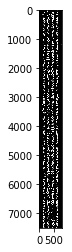

In [4]:
img_array = np.load('MNIST/train_data.npy')
plt.imshow(img_array, cmap="gray")
img_name = "fl"+".png"
matplotlib.image.imsave(img_name, img_array)
# print('MNIST/train_data.npy')

In [5]:
## Print out their dimensions
print("Training dataset dimensions: ", np.shape(train_data))
print("Number of training labels: ", len(train_labels))
print("Testing dataset dimensions: ", np.shape(test_data))
print("Number of testing labels: ", len(test_labels))

('Training dataset dimensions: ', (7500, 784))
('Number of training labels: ', 7500)
('Testing dataset dimensions: ', (1000, 784))
('Number of testing labels: ', 1000)


In [6]:
## Compute the number of examples of each digit
train_digits, train_counts = np.unique(train_labels, return_counts=True)
print("Training set distribution:")
print(dict(zip(train_digits, train_counts)))

test_digits, test_counts = np.unique(test_labels, return_counts=True)
print("Test set distribution:")
print(dict(zip(test_digits, test_counts)))

Training set distribution:
{0: 750, 1: 750, 2: 750, 3: 750, 4: 750, 5: 750, 6: 750, 7: 750, 8: 750, 9: 750}
Test set distribution:
{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100}


## 2. Visualizing the data
Each data point is stored as 784-dimensional vector. To visualize a data point, we first reshape it to a 28x28 image.

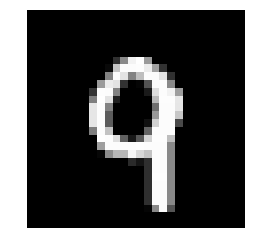

Label 9


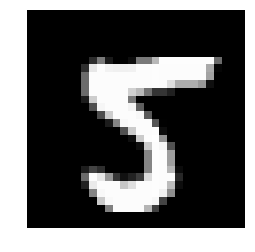

Label 5


In [7]:
## Define a function that displays a digit given its vector representation
def show_digit(x):
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()
    return

## Define a function that takes an index into a particular data set ("train" or "test") and displays that image.
def vis_image(index, dataset="train"):
    if(dataset=="train"): 
        show_digit(train_data[index,])
        label = train_labels[index]
    else:
        show_digit(test_data[index,])
        label = test_labels[index]
    print("Label " + str(label))
    return

## View the first data point in the training set
vis_image(0, "train")

## Now view the first data point in the test set
# vis_image(0, "test")
vis_image(3, "test")

## 3. Squared Euclidean distance

To compute nearest neighbors in our data set, we need to first be able to compute distances between data points. A natural distance function is _Euclidean distance_: for two vectors $x, y \in \mathbb{R}^d$, their Euclidean distance is defined as 
$$\|x - y\| = \sqrt{\sum_{i=1}^d (x_i - y_i)^2}.$$
Often we omit the square root, and simply compute _squared Euclidean distance_:
$$\|x - y\|^2 = \sum_{i=1}^d (x_i - y_i)^2.$$
For the purposes of nearest neighbor computations, the two are equivalent: for three vectors $x, y, z \in \mathbb{R}^d$, we have $\|x - y\| \leq \|x - z\|$ if and only if $\|x - y\|^2 \leq \|x - z\|^2$.

Now we just need to be able to compute squared Euclidean distance. The following function does so.

In [8]:
## Computes squared Euclidean distance between two vectors.
def squared_dist(x,y):
    # print(x)
    return np.sum(np.square(x-y))

## Compute distance between a seven and a one in our training set.
print("Distance from 7 to 1: ", squared_dist(train_data[4,],train_data[5,]))


## Compute distance between a seven and a two in our training set.
print("Distance from 7 to 2: ", squared_dist(train_data[4,],train_data[1,]))

## Compute distance between two seven's in our training set.
print("Distance from 7 to 7: ", squared_dist(train_data[4,],train_data[7,]))

('Distance from 7 to 1: ', 5357193.0)
('Distance from 7 to 2: ', 12451684.0)
('Distance from 7 to 7: ', 5223403.0)


## 4. Computing nearest neighbors

Now that we have a distance function defined, we can now turn to nearest neighbor classification. 

In [14]:
## Takes a vector x and returns the index of its nearest neighbor in train_data
def find_NN(x):
    # Compute distances from x to every row in train_data
    distances = [squared_dist(x,train_data[i,]) for i in range(len(train_labels))]
    # Get the index of the smallest distance
    # print(distances)
    return np.argmin(distances)

## Takes a vector x and returns the class of its nearest neighbor in train_data
def NN_classifier(x):
    # Get the index of the the nearest neighbor
    index = find_NN(x)
    #print(index,'index')
    # Return its class
    return train_labels[index]

A success case:
(7495, 'index')
('NN classification: ', 5)
('True label: ', 5)
The test image:


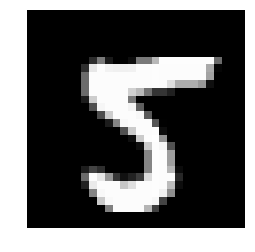

Label 5
The corresponding nearest neighbor image:


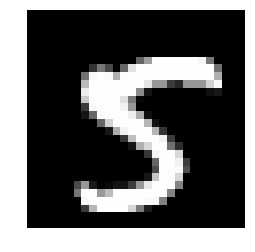

Label 5


In [10]:
## A success case:
print("A success case:")
print("NN classification: ", NN_classifier(test_data[3,]))
print("True label: ", test_labels[3])
print("The test image:")
vis_image(3, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_NN(test_data[3,]), "train")

A failure case:
(4455, 'index')
('NN classification: ', 2)
('True label: ', 3)
The test image:


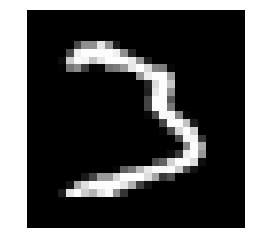

Label 3
The corresponding nearest neighbor image:


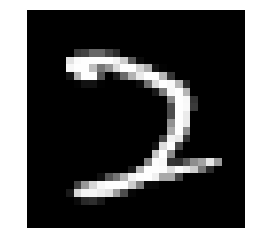

Label 2


In [11]:
## A failure case:
print("A failure case:")
print("NN classification: ", NN_classifier(test_data[39,]))
print("True label: ", test_labels[39])
print("The test image:")
vis_image(39, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_NN(test_data[39,]), "train")

## 6. Processing the full test set

Now let's apply our nearest neighbor classifier over the full data set. 

Note that to classify each test point, our code takes a full pass over each of the 7500 training examples. Thus we should not expect testing to be very fast. The following code takes about 100-150 seconds on 2.6 GHz Intel Core i5. 

In [15]:
## Predict on each test data point (and time it!)
t_before = time.time()
test_predictions = [NN_classifier(test_data[i,]) for i in range(len(test_labels))]
t_after = time.time()

## Compute the error
err_positions = np.not_equal(test_predictions, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print("Error of nearest neighbor classifier: ", error)
print("Classification time (seconds): ", t_after - t_before)

('Error of nearest neighbor classifier: ', 0.046)
('Classification time (seconds): ', 45.800344944000244)
